<a href="https://colab.research.google.com/github/emanueleiacca/ADM-HW4/blob/main/DataPreparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
#movielens_20m_dataset_path = kagglehub.dataset_download('grouplens/movielens-20m-dataset')
print('Data source import complete.')


Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


https://github.com/rapidsai/cudf?tab=readme-ov-file#pip

In [4]:
pip install --extra-index-url=https://pypi.nvidia.com cudf-cu12

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com


In [5]:
import rmm
import cudf
rmm.reinitialize(pool_allocator=True, managed_memory=True)
print("RAPIDS cuDF is using GPU memory:", rmm.is_initialized())

RAPIDS cuDF is using GPU memory: True


In [6]:
import cupy as cp

def check_memory():
    memory_pool = cp.get_default_memory_pool()
    total_memory = cp.cuda.Device(0).mem_info[0]  # Total memory available
    used_memory = memory_pool.used_bytes()       # Memory allocated by the pool
    free_memory = total_memory - used_memory
    print(f"GPU Memory - Total: {total_memory / (1024**3):.2f} GB, Used: {used_memory / (1024**3):.2f} GB, Free: {free_memory / (1024**3):.2f} GB")

check_memory()

GPU Memory - Total: 14.65 GB, Used: 0.00 GB, Free: 14.65 GB


In [7]:
movielens_20m_dataset_path = kagglehub.dataset_download('grouplens/movielens-20m-dataset')

# Percorso ai file del dataset scaricato
dataset_directory = '/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1'

# Elenca e stampa i file presenti nella directory del dataset
for dirname, _, filenames in os.walk(dataset_directory):
    for filename in filenames:
        print(f"File trovato: {filename}")

100%|██████████| 195M/195M [00:10<00:00, 20.0MB/s]

Extracting files...


File trovato: genome_scores.csv
File trovato: tag.csv
File trovato: movie.csv
File trovato: genome_tags.csv
File trovato: rating.csv
File trovato: link.csv


In [8]:
ratings_df = cudf.read_csv("/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1/rating.csv")
links_df = cudf.read_csv("/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1/link.csv")
genome_tags_df = cudf.read_csv("/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1/genome_tags.csv")
genome_scores_df = cudf.read_csv("/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1/genome_scores.csv")
tags_df = cudf.read_csv("/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1/tag.csv")
movies_df = cudf.read_csv("/root/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1/movie.csv")


In [ ]:
check_memory()

GPU Memory - Total: 12.14 GB, Used: 0.00 GB, Free: 12.14 GB


In [ ]:
print("ratings_df:",ratings_df.columns)
print("links_df:",links_df.columns)
print("genome_tags_df:",genome_tags_df.columns)
print("genome_scores_df:",genome_scores_df.columns)
print("tags_df:",tags_df.columns)
print("movies_df:",movies_df.columns)

ratings_df: Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')
links_df: Index(['movieId', 'imdbId', 'tmdbId'], dtype='object')
genome_tags_df: Index(['tagId', 'tag'], dtype='object')
genome_scores_df: Index(['movieId', 'tagId', 'relevance'], dtype='object')
tags_df: Index(['userId', 'movieId', 'tag', 'timestamp'], dtype='object')
movies_df: Index(['movieId', 'title', 'genres'], dtype='object')


In [ ]:
import gc
rmm.reinitialize(pool_allocator=True, managed_memory=True)  # Reset GPU memory
movies_links = movies_df.merge(links_df, on="movieId", how="left")
del links_df  # Free up memory
gc.collect()
movies_links.head()

,movieId,title,genres,imdbId,tmdbId
0,1571,When the Cat's Away (Chacun cherche son chat) ...,Comedy|Romance,115856,11956
1,1572,"Contempt (Mépris, Le) (1963)",Drama,57345,266
2,1573,Face/Off (1997),Action|Crime|Drama|Thriller,119094,754
3,1574,Fall (1997),Romance,119098,37567
4,1575,Gabbeh (1996),Drama,116384,43771


In [ ]:
# Merge ratings with movies
rmm.reinitialize(pool_allocator=True, managed_memory=True)  # Reset GPU memory
ratings_movies = ratings_df.merge(movies_links, on="movieId", how="left")
del ratings_df, movies_links  # Free up memory
gc.collect()
ratings_movies.head()

,userId,movieId,rating,timestamp,title,genres,imdbId,tmdbId
0,91,1777,3.5,2005-09-12 06:51:11,"Wedding Singer, The (1998)",Comedy|Romance,120888,11003
1,91,1784,4.5,2005-03-22 22:41:47,As Good as It Gets (1997),Comedy|Drama|Romance,119822,2898
2,91,1876,2.5,2005-09-12 06:56:26,Deep Impact (1998),Drama|Sci-Fi|Thriller,120647,8656
3,91,1907,3.5,2005-03-23 06:27:08,Mulan (1998),Adventure|Animation|Children|Comedy|Drama|Musi...,120762,10674
4,91,1909,3.0,2005-04-11 06:37:49,"X-Files: Fight the Future, The (1998)",Action|Crime|Mystery|Sci-Fi|Thriller,120902,846


In [ ]:
rmm.reinitialize(pool_allocator=True, managed_memory=True)  # Reset GPU memory
# Merge genome scores with genome tags
genome_data = genome_scores_df.merge(genome_tags_df, on="tagId", how="left")
del genome_tags_df  # Free up memory
gc.collect()
genome_data.head()

,movieId,tagId,relevance,tag
0,3,977,0.08250,stunning
1,3,978,0.03875,stupid
2,3,979,0.07550,stupid as hell
3,3,980,0.05450,stupidity
4,3,981,0.07175,stylish


In [ ]:
rmm.reinitialize(pool_allocator=True, managed_memory=True)
# Merge tags with movies
tags_movies = tags_df.merge(movies_df, on="movieId", how="left")
del tags_df  # Free up memory
gc.collect()
tags_movies.head()

,userId,movieId,tag,timestamp,title,genres
0,1741,280,courtroom setting,2007-05-12 04:05:38,Murder in the First (1995),Drama|Thriller
1,1741,288,serial killer,2007-08-18 02:59:59,Natural Born Killers (1994),Action|Crime|Thriller
2,1741,290,rape,2009-05-01 01:06:12,Once Were Warriors (1994),Crime|Drama
3,1741,293,assassin,2009-01-15 19:38:24,Léon: The Professional (a.k.a. The Professiona...,Action|Crime|Drama|Thriller
4,1741,293,assassin-in-training,2009-01-15 19:40:03,Léon: The Professional (a.k.a. The Professiona...,Action|Crime|Drama|Thriller


In [ ]:
check_memory()

GPU Memory - Total: 9.14 GB, Used: 0.00 GB, Free: 9.14 GB


In [ ]:
print("ratings_movies:",ratings_movies.columns)
print("genome_data:",genome_data.columns)
print("tags_movies:",tags_movies.columns)

ratings_movies: Index(['userId', 'movieId', 'rating', 'timestamp', 'title', 'genres', 'imdbId',
       'tmdbId'],
      dtype='object')
genome_data: Index(['movieId', 'tagId', 'relevance', 'tag'], dtype='object')
tags_movies: Index(['userId', 'movieId', 'tag', 'timestamp', 'title', 'genres'], dtype='object')


In [ ]:
ratings_movies = ratings_movies[["userId", "movieId", "rating", "title", "genres","timestamp"]]
genome_data = genome_data[["movieId", "tag", "relevance"]]
tags_movies = tags_movies[["userId", "movieId", "tag"]]
#Remove repeated columns

In [ ]:
print("ratings_movies:",ratings_movies.info())
print("genome_data:",genome_data.info())
print("tags_movies:",tags_movies.info())

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 6 columns):
 #   Column     Dtype
---  ------     -----
 0   userId     int64
 1   movieId    int64
 2   rating     float64
 3   title      object
 4   genres     object
 5   timestamp  object
dtypes: float64(1), int64(2), object(3)
memory usage: 1.8+ GB
ratings_movies: None
<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 11709768 entries, 0 to 11709767
Data columns (total 3 columns):
 #   Column     Dtype
---  ------     -----
 0   movieId    int64
 1   tag        object
 2   relevance  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 335.2+ MB
genome_data: None
<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 465426 entries, 0 to 465425
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   userId   465426 non-null  int64
 1   movieId  465426 non-null  int64
 2   tag      465426 non-null  object
dtypes: int

1.1

In [12]:
movies_df_pd = movies_df.to_pandas()

In [27]:
movies_df_pd=movies_df_pd.drop_duplicates()

In [37]:
ratings_df_pd = ratings_df.to_pandas()  # Convert to Pandas DataFrame



In [28]:
ratings_df_pd = ratings_df_pd.drop_duplicates()

In [31]:
print("\nInformazioni sul dataset 'movies':")
print(movies_df_pd.info())

print("\nInformazioni sul dataset 'ratings':")
print(ratings_df_pd.info())


Informazioni sul dataset 'movies':
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  27278 non-null  int64 
 1   title    27278 non-null  object
 2   genres   27278 non-null  object
dtypes: int64(1), object(2)
memory usage: 639.5+ KB
None

Informazioni sul dataset 'ratings':
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 610.4+ MB
None


In [32]:
print(movies_df_pd.isnull().sum())
print(movies_df_pd.isna().sum())
print(movies_df_pd.duplicated().sum())

movieId    0
title      0
genres     0
dtype: int64
movieId    0
title      0
genres     0
dtype: int64
0


In [33]:
print(ratings_df_pd.isnull().sum())
print(ratings_df_pd.isna().sum())
print(ratings_df_pd.duplicated().sum())

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
0


In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD

movies_df_pd['genres'] = movies_df_pd['genres'].str.replace('|', ' ')
tfidf = TfidfVectorizer(stop_words='english')


In [35]:
print("\nStatistiche descrittive per il dataset 'ratings':")
print(ratings_df_pd.describe())

print("\nStatistiche descrittive per il dataset 'movies':")
print(movies_df_pd.describe(include='all'))  # Include anche le colonne non numeriche


Statistiche descrittive per il dataset 'ratings':
             userId       movieId        rating
count  2.000026e+07  2.000026e+07  2.000026e+07
mean   6.904587e+04  9.041567e+03  3.525529e+00
std    4.003863e+04  1.978948e+04  1.051989e+00
min    1.000000e+00  1.000000e+00  5.000000e-01
25%    3.439500e+04  9.020000e+02  3.000000e+00
50%    6.914100e+04  2.167000e+03  3.500000e+00
75%    1.036370e+05  4.770000e+03  4.000000e+00
max    1.384930e+05  1.312620e+05  5.000000e+00

Statistiche descrittive per il dataset 'movies':
              movieId           title genres
count    27278.000000           27278  27278
unique            NaN           27262   1342
top               NaN  Aladdin (1992)  Drama
freq              NaN               2   4520
mean     59855.480570             NaN    NaN
std      44429.314697             NaN    NaN
min          1.000000             NaN    NaN
25%       6931.250000             NaN    NaN
50%      68068.000000             NaN    NaN
75%     100293.25

In [38]:
user_movies = ratings_df_pd.groupby('userId')['movieId'].apply(set).to_dict()

In [40]:
def jaccard_similarity_hashed(signature1, signature2):
    matches = sum(1 for x, y in zip(signature1, signature2) if x == y)
    return matches / len(signature1)

In [41]:
def generate_hash_function(a,b,c):
    def hash_function(x):
        return (a * (x%c) + b)
    return hash_function

def generate_hash_functions(num_hashes, max_movie_id, seed=None):
    """Genera una famiglia di funzioni hash lineari."""
    if seed is not None:
        np.random.seed(seed)
    a = np.random.randint(1, max_movie_id * 2, size=num_hashes)
    b = np.random.randint(0, max_movie_id * 2, size=num_hashes)
    c = max_movie_id * 2 + 1  # Numero primo maggiore
    return [generate_hash_function(a_, b_, c) for a_, b_ in zip(a, b)]

In [42]:
def create_custom_hash_function(a_coeff, b_coeff, prime_mod):
    """Definisce una funzione hash personalizzata basata sul parametro 2x."""
    def hash_function(input_value):
        return (a_coeff * 2 * input_value + b_coeff) % prime_mod
    return hash_function

def create_hash_function_family(num_functions, max_movie_val, random_seed=None):
    """Genera una serie di funzioni hash utilizzando il coefficiente 2x nella formula."""
    if random_seed is not None:
        np.random.seed(random_seed)

    a_coefficients = np.random.randint(1, max_movie_val * 2, size=num_functions)
    b_coefficients = np.random.randint(0, max_movie_val * 2, size=num_functions)
    prime_modulo = max_movie_val * 2 + 1  # Modulo primo più grande del massimo valore

    return [create_custom_hash_function(a, b, prime_modulo) for a, b in zip(a_coefficients, b_coefficients)]

In [43]:
def create_quadratic_hash_function(coeff_a, coeff_b, prime_modulo):
    """Crea una funzione hash quadratica basata su x^2 nella formula."""
    def hash_function(input_value):
        return (coeff_a * (input_value / 2) + coeff_b * input_value) % prime_modulo
    return hash_function

def create_quadratic_hash_family(num_functions, max_val, random_seed=None):
    """Genera una famiglia di funzioni hash quadratiche."""
    if random_seed is not None:
        np.random.seed(random_seed)

    coeff_a_list = np.random.randint(1, max_val * 2, size=num_functions)
    coeff_b_list = np.random.randint(0, max_val * 2, size=num_functions)
    prime_modulo = max_val * 2 + 1  # Modulo primo maggiore del massimo valore

    return [create_quadratic_hash_function(a, b, prime_modulo) for a, b in zip(coeff_a_list, coeff_b_list)]

In [44]:
def create_cubic_hash_function(coeff_a, coeff_b, prime_mod):
    """Definisce una funzione hash cubica basata su x^3."""
    def hash_function(input_val):
        return (coeff_a * input_val**3 + coeff_b) % prime_mod
    return hash_function

def create_cubic_hash_family(num_functions, max_val, random_seed=None):
    """Genera una famiglia di funzioni hash cubiche."""
    if random_seed is not None:
        np.random.seed(random_seed)

    a_coeffs = np.random.randint(1, max_val * 2, size=num_functions)  # Coefficienti 'a'
    b_coeffs = np.random.randint(0, max_val * 2, size=num_functions)  # Coefficienti 'b'
    prime_modulo = max_val * 2 + 1  # Primo numero maggiore di max_val

    return [create_cubic_hash_function(a, b, prime_modulo) for a, b in zip(a_coeffs, b_coeffs)]

In [45]:
def generate_signatures(subset_users, user_movie_data, hash_functions):
    """Crea le firme MinHash per un gruppo specifico di utenti."""
    signatures = {}

    for user_id in subset_users:
        watched_movies = user_movie_data.get(user_id, set())

        if not watched_movies:
            # Se l'utente non ha film valutati, assegna una firma "vuota" (infinito)
            signatures[user_id] = [float('inf')] * len(hash_functions)
            continue

        user_signature = []
        for hash_func in hash_functions:
            # Trova il valore hash minimo per i film associati all'utente
            min_hash_value = min(hash_func(movie) for movie in watched_movies)
            user_signature.append(min_hash_value)

        signatures[user_id] = user_signature

    return signatures

In [46]:
def compute_mse(user_movie_data, signatures, selected_users):
    """Calcola l'errore quadratico medio (MSE) tra similarità reali e stimate per un insieme di utenti."""
    total_error = 0
    pair_count = 0

    for idx, user_a in enumerate(selected_users):
        for user_b in selected_users[idx + 1:]:
            # Similarità reale basata sulla definizione di Jaccard
            actual_jaccard = jaccard_similarity_hashed(user_movie_data[user_a], user_movie_data[user_b])

            # Similarità stimata utilizzando le firme MinHash
            estimated_jaccard = jaccard_similarity_hashed(signatures[user_a], signatures[user_b])

            # Aggiunge l'errore quadratico alla somma totale
            total_error += (actual_jaccard - estimated_jaccard) ** 2
            pair_count += 1

    # Calcola l'errore medio quadratico
    return (total_error / pair_count) if pair_count > 0 else 0

In [47]:
# Seleziona un sottoinsieme di utenti e crea il dizionario dei loro film
selected_users = list(user_movies.keys())[:100]
selected_user_movies = {user: user_movies[user] for user in selected_users}

# Genera diverse famiglie di funzioni hash
hash_funcs_default = create_hash_function_family(
    num_functions=10,
    max_movie_val=ratings_df['movieId'].max(),
    random_seed=42
)

hash_funcs_2x = create_hash_function_family(
    num_functions=10,
    max_movie_val=ratings_df['movieId'].max(),
    random_seed=42
)

hash_funcs_quadratic = create_quadratic_hash_family(
    num_functions=10,
    max_val=ratings_df['movieId'].max(),
    random_seed=42
)

hash_funcs_cubic = create_cubic_hash_family(
    num_functions=10,
    max_val=ratings_df['movieId'].max(),
    random_seed=42
)

# Calcola le firme MinHash per ciascun tipo di funzione hash
signatures_default = generate_signatures(selected_users, selected_user_movies, hash_funcs_default)
signatures_2x = generate_signatures(selected_users, selected_user_movies, hash_funcs_2x)
signatures_quadratic = generate_signatures(selected_users, selected_user_movies, hash_funcs_quadratic)
signatures_cubic = generate_signatures(selected_users, selected_user_movies, hash_funcs_cubic)

# Calcola l'errore quadratico medio (MSE) per ciascuna configurazione
mse_default = compute_mse(user_movies, signatures_default, selected_users)
mse_2x = compute_mse(user_movies, signatures_2x, selected_users)
mse_quadratic = compute_mse(user_movies, signatures_quadratic, selected_users)
mse_cubic = compute_mse(user_movies, signatures_cubic, selected_users)

<ipython-input-44-94dcfa41f9ff>:4: RuntimeWarning: overflow encountered in scalar multiply
  return (coeff_a * input_val**3 + coeff_b) % prime_mod


In [48]:
print(f"MSE: {mse_default:.4f}")

print(f"MSE con moltiplicazione 2x: {mse_2x:.4f}")

print(f"MSE con x^2: {mse_quadratic:.4f}")

print(f"MSE con x^3: {mse_cubic:.4f}")

MSE: 0.0081
MSE con moltiplicazione 2x: 0.0081
MSE con x^2: 0.0048
MSE con x^3: 0.0088


In [49]:
threshold_real = 0.1  # Soglia per la similarità reale (Jaccard)

real_similarities = []
estimated_similarities = []

for i, user1 in enumerate(selected_users):
    for user2 in selected_users[i+1:]:
        # Calcola la similarità reale (Jaccard)
        real_sim = jaccard_similarity_hashed(user_movies[user1], user_movies[user2])

        if real_sim > threshold_real:
            real_similarities.append(real_sim)

            # Calcola la similarità stimata (MinHash)
            estimated_sim = jaccard_similarity_hashed(signatures_quadratic[user1], signatures_quadratic[user2])
            estimated_similarities.append(estimated_sim)


In [50]:
threshold_estimated = 0.1  # Soglia per la similarità stimata (MinHash)

real_similarities = []
estimated_similarities = []

for i, user1 in enumerate(selected_users):
    for user2 in selected_users[i+1:]:
        # Calcola la similarità reale (Jaccard)
        real_sim = jaccard_similarity_hashed(user_movies[user1], user_movies[user2])
        real_similarities.append(real_sim)

        # Calcola la similarità stimata (MinHash)
        estimated_sim = jaccard_similarity_hashed(signatures_quadratic[user1], signatures_quadratic[user2])

        if estimated_sim > threshold_estimated:
            estimated_similarities.append(estimated_sim)

In [51]:
threshold_real = 0.1  # Soglia per la similarità reale (Jaccard)
threshold_estimated = 0.1  # Soglia per la similarità stimata (MinHash)

real_similarities = []
estimated_similarities = []

for i, user1 in enumerate(selected_users):
    for user2 in selected_users[i+1:]:
        # Calcola la similarità reale (Jaccard)
        real_sim = jaccard_similarity_hashed(user_movies[user1], user_movies[user2])

        # Se la similarità reale supera la soglia, calcola anche la similarità stimata
        if real_sim > threshold_real:
            real_similarities.append(real_sim)

            # Calcola la similarità stimata (MinHash)
            estimated_sim = jaccard_similarity_hashed(signatures_quadratic[user1], signatures_quadratic[user2])

            if estimated_sim > threshold_estimated:
                estimated_similarities.append(estimated_sim)

In [52]:
from sklearn.metrics import precision_score, recall_score, f1_score

thresholds = np.linspace(0, 1, 11)  # Threshold da 0 a 1 con passo 0.1
results = []

for threshold in thresholds:
    # Determina le coppie "simili" reali e stimate, usando la stessa logica per entrambe
    real_labels = []
    estimated_labels = []
    for real_sim, estimated_sim in zip(real_similarities, estimated_similarities):
        real_labels.append(1 if real_sim >= threshold else 0)
        estimated_labels.append(1 if estimated_sim >= threshold else 0)

    # Calcola le metriche
    precision = precision_score(real_labels, estimated_labels, zero_division=0)
    recall = recall_score(real_labels, estimated_labels, zero_division=0)
    f1 = f1_score(real_labels, estimated_labels, zero_division=0)

    # Salva i risultati
    results.append((threshold, precision, recall, f1))

# Visualizzazione dei risultati

results_df = pd.DataFrame(results, columns=["Threshold", "Precision", "Recall", "F1-Score"])
print(results_df)

    Threshold  Precision  Recall  F1-Score
0         0.0        1.0     1.0  1.000000
1         0.1        1.0     1.0  1.000000
2         0.2        0.2     1.0  0.333333
3         0.3        0.0     0.0  0.000000
4         0.4        0.0     0.0  0.000000
5         0.5        0.0     0.0  0.000000
6         0.6        0.0     0.0  0.000000
7         0.7        0.0     0.0  0.000000
8         0.8        0.0     0.0  0.000000
9         0.9        0.0     0.0  0.000000
10        1.0        0.0     0.0  0.000000


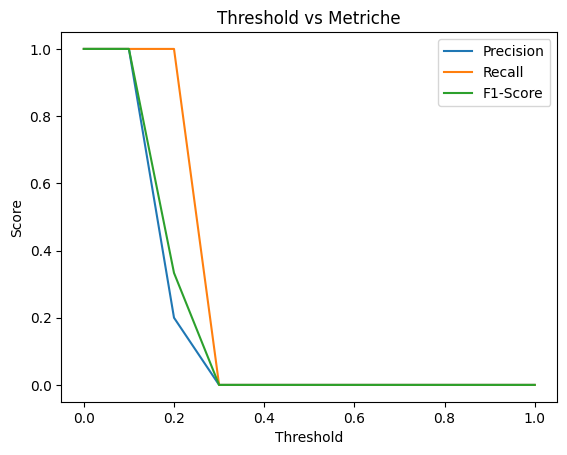

In [53]:
import matplotlib.pyplot as plt

plt.plot(results_df["Threshold"], results_df["Precision"], label="Precision")
plt.plot(results_df["Threshold"], results_df["Recall"], label="Recall")
plt.plot(results_df["Threshold"], results_df["F1-Score"], label="F1-Score")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold vs Metriche")
plt.legend()
plt.show()

In [54]:
optimal_threshold = results_df.loc[results_df['F1-Score'].idxmax(), 'Threshold']

print(f"Threshold ottimale (basato su F1-Score): {optimal_threshold}")


Threshold ottimale (basato su F1-Score): 0.0
